#Installing the libraries#

In [ ]:
pip install mlmorph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 25.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.6/371.6 kB 16.6 MB/s eta 0:00:00
  Created wheel for mlmorph: filename=mlmorph-1.4.0-py3-none-any.whl size=5693382 sha256=baae200fba920003e1466297e213d7c820139d01b70a6b0155c474a3320f9cc6
  Stored in directory: /root/.cache/pip/wheels/6d/01/32/357a7a5b8dee3bfbb3164e6d7daa99a8b45033c4f125a929e3
Successfully built mlmorph


In [ ]:
from transformers import pipeline                     # Import transformers

from collections import Counter                       # Cosine similarity
from math import sqrt

import pandas as pd                                   # Printing output of error metrics as a table

from mlmorph import Analyser                          # Morphologically splitting the words
import re

from google.colab import drive                        # Access images

from IPython.display import display, HTML             # Display the images in a table form
import base64

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


#Generating answers from question and context using 3 transformer models -  Roberta large, MURIL and MBERT models#

In [ ]:
malayalam_contexts = ["എന്റെ നായ ചത്തതിനാൽ എനിക്ക് സങ്കടം തോന്നുന്നു.",
                      "മഴ പെയ്യാൻ സാധ്യതയുണ്ട്, അതുകൊണ്ട് എന്റെ കയ്യിൽ ഒരു കുടയുണ്ട്.",
                      "പൂക്കളുടെ സുഗന്ധം പരത്തി ഒരു ഇളം കാറ്റ് വീശി.",
                      "ദൈവങ്ങൾ മനുഷ്യ ലോകത്തിന് പുറത്തുള്ള സ്വർഗത്തിലാണ് ജീവിക്കുന്നത്.",
                      "ഇല്ല, എനിക്ക് അസുഖമില്ല, കുറച്ചു ക്ഷീണമുണ്ട്.",
                      "നേതാവ് പോയതിനുശേഷം ഞാൻ ആളുകളെ അറിയിച്ചു.",
                      "ഇന്ത്യയെ ആക്രമിച്ച പ്രശസ്തനായ ഒരു ജേതാവായിരുന്നു അലക്സാണ്ടർ.",
                      "ഇപ്പോൾ സമയം വൈകുന്നേരം ഏഴ്, എനിക്ക് അത്താഴത്തിന് പോകണം.",
                      "എന്റെ പ്രിയപ്പെട്ട ദൈവമായ കൃഷ്ണൻ നീല നിറത്തിലാണ്.",
                      "ആ കുട്ടി വളരെ ക്ഷീണിതനാണ്, അതുകൊണ്ട് അവൻ ഉറങ്ങുകയാണ്.",
                      "രാജാവ് കൗൺസിലിൽ ഇരുന്ന് ഒരു യോഗത്തിൽ പങ്കെടുക്കുകയാണ്.",
                      "മുതല പുഴയിൽ മീൻ പിടിക്കാൻ ശ്രമിക്കുന്നു.",
                      "രാത്രി ആകാശത്ത് ചന്ദ്രനും നക്ഷത്രങ്ങളും മിന്നുന്നു.",
                      "പാമ്പും കീരിയും ആയുള്ള പോരാട്ടത്തിൽ കീരി ജയിച്ചു, പാമ്പ് തോറ്റു.",
                      "ഇന്നലെ ഞാൻ എന്റെ ചെവിക്ക് കമ്മലുകൾ വാങ്ങി.",
                      "ഉച്ചകഴിഞ്ഞ് പുറത്തെ സൂര്യകിരണങ്ങൾ ശക്തമാണ്.",
                      "ഇന്നു രാത്രി ചന്ദ്രൻ ഇല്ല, അതു കൊണ്ട് നല്ല ഇരുട്ടാണ്",
                      "ഉണങ്ങാൻ വേണ്ടി അവൾ വസ്ത്രങ്ങൾ വിടർത്തുന്നു."]

In [ ]:
malayalam_questions = ["നിനക്ക് എന്തുതോന്നുന്നു?",
                        "കയ്യിൽ എന്താണ് ഉള്ളത്?",
                        "എന്താണ് ആ സുഗന്ധം?",
                        "ദൈവങ്ങൾ എവിടെയാണ് താമസിക്കുന്നത്?",
                        "നിനക്ക് അസുഖമാണോ?",
                        "നീ ആരെ അറിയിച്ചു?",
                        "എന്തുകൊണ്ടാണ് അലക്സാണ്ടർ ഇത്ര പ്രധാനമായിരിക്കുന്നത്?",
                        "ഇപ്പോൾ സമയം എത്രയായി?",
                        "നിങ്ങൾക്ക് ഏറ്റവും പ്രിയപ്പെട്ടത് ഏത് ദൈവത്തെയാണ്?",
                        "അവൻ എന്താണ് ചെയ്യുന്നത്?",
                        "രാജാവ് എവിടെയാണ്?",
                        "മുതല എവിടെ?",
                        "രാത്രി ആകാശത്ത് മിന്നുന്ന വസ്തുക്കൾ എന്തൊക്കെയാണ്?",
                        "പോരാട്ടത്തിൽ ആരാണ് ജയിച്ചത്?",
                        "നിങ്ങൾ എന്താണ് വാങ്ങിയത്?",
                        "പുറത്ത് എന്താണ് ഇത്ര വെളിച്ചം?",
                        "പുറത്ത് എന്തുകൊണ്ടാണ് ഇത്ര ഇരുട്ട്?",
                        "അവൾ എന്താണ് ചെയ്യുന്നത്?"]

In [ ]:
malayalam_actual_answers = ["സങ്കടം",
                             "ഒരു കുട",
                             "പൂക്കൾ",
                             "സ്വർഗം",
                             "എനിക്ക് അസുഖമില്ല",
                             "ആളുകൾ",
                             "അദ്ദേഹം ഇന്ത്യയെ ആക്രമിച്ചു",
                             "വൈകുന്നേരം ഏഴ്",
                             "കൃഷ്ണൻ",
                             "ഉറങ്ങുകയാണ്",
                             "കൗൺസിലിൽ",
                             "പുഴയിൽ",
                             "ചന്ദ്രനും നക്ഷത്രങ്ങളും",
                             "കീരി ജയിച്ചു",
                             "കമ്മലുകൾ",
                             "സൂര്യകിരണങ്ങൾ",
                             "ചന്ദ്രനില്ല",
                             "വസ്ത്രങ്ങൾ വിടർത്തുന്നു"]

In [ ]:
# xlm-roberta-large

malayalam_generated_answers_roberta_large = []
qa_pipeline = pipeline("question-answering", model="deepset/xlm-roberta-large-squad2", tokenizer="xlm-roberta-large")

for i in range(len(malayalam_questions)):
  result = qa_pipeline(question = malayalam_questions[i], context = malayalam_contexts[i])
  #print(result['answer'])
  malayalam_generated_answers_roberta_large.append(result["answer"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/606 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
malayalam_generated_answers_roberta_large

['സങ്കടം തോന്നുന്നു.',
 'ഒരു കുടയുണ്ട്.',
 'പൂക്കളുടെ',
 'സ്വർഗത്തിലാണ് ജീവിക്കുന്നത്.',
 'എനിക്ക് അസുഖമില്ല,',
 'ആളുകളെ അറിയിച്ചു.',
 'പ്രശസ്തനായ ഒരു ജേതാവായിരുന്നു അലക്സാണ്ടർ.',
 'വൈകുന്നേരം ഏഴ്,',
 'കൃഷ്ണൻ',
 'ഉറങ്ങുകയാണ്.',
 'കൗൺസിലിൽ',
 'മുതല',
 'ചന്ദ്രനും നക്ഷത്രങ്ങളും',
 'കീരി',
 'കമ്മലുകൾ',
 'സൂര്യകിരണങ്ങൾ ശക്തമാണ്.',
 'ചന്ദ്രൻ ഇല്ല,',
 'വസ്ത്രങ്ങൾ വിടർത്തുന്നു.']

In [ ]:
# MURIL

malayalam_generated_answers_muril = []
qa_pipeline = pipeline("question-answering", model="google/muril-base-cased", tokenizer="google/muril-base-cased")

for i in range(len(malayalam_questions)):
  result = qa_pipeline(question = malayalam_questions[i], context = malayalam_contexts[i])
  #print(result['answer'])
  malayalam_generated_answers_muril.append(result["answer"])

config.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/953M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/953M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/113 [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
malayalam_generated_answers_muril

['എന്റെ നായ ചത്തതിനാൽ',
 'പെയ്യാൻ സാധ്യതയുണ്ട്, അതുകൊണ്ട് എന്റെ കയ്യിൽ ഒരു കുടയുണ്ട്',
 'പരത്തി ഒരു ഇളം കാറ്റ് വീശി',
 'സ്വർഗത്തിലാണ്',
 'ഇല്ല,',
 'പോയതിനുശേഷം ഞാൻ ആളുകളെ അറിയിച്ചു',
 'പ്രശസ്തനായ ഒരു',
 'വൈകുന്നേരം ഏഴ്,',
 'ദൈവമായ കൃഷ്ണൻ',
 'ആ കുട്ടി വളരെ ക്ഷീണിതനാണ്',
 'ഒരു യോഗത്തിൽ പങ്കെടുക്കുകയാണ്',
 'പുഴയിൽ',
 'ആകാശത്ത് ചന്ദ്രനും',
 'കീരി',
 'ഇന്നലെ ഞാൻ എന്റെ ചെവിക്ക് കമ്മലുകൾ',
 'സൂര്യകിരണങ്ങൾ ശക്തമാണ്',
 'ചന്ദ്രൻ ഇല്ല, അതു',
 'ഉണങ്ങാൻ വേണ്ടി അവൾ വസ്ത്രങ്ങൾ വിടർത്തുന്നു']

In [ ]:
# MBERT

malayalam_generated_answers_mbert = []
qa_pipeline = pipeline("question-answering", model="bert-base-multilingual-cased", tokenizer="bert-base-multilingual-cased")

for i in range(len(malayalam_questions)):
  result = qa_pipeline(question = malayalam_questions[i], context = malayalam_contexts[i])
  #print(result['answer'])
  malayalam_generated_answers_mbert.append(result["answer"])

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
malayalam_generated_answers_mbert

['എന്റെ നായ ചത്തതിനാൽ എനിക്ക് സങ്കടം',
 'എന്റെ',
 'സുഗന്ധം പരത്തി ഒരു ഇളം',
 'ദൈവങ്ങൾ മനുഷ്യ ലോകത്തിന്',
 'അസുഖമില്ല, കുറച്ചു',
 'പോയതിനുശേഷം',
 'ആക്രമിച്ച',
 'എനിക്ക് അത്താഴത്തിന് പോകണം',
 'പ്രിയപ്പെട്ട',
 'ക്ഷീണിതനാണ്, അതുകൊണ്ട് അവൻ ഉറങ്ങുകയാണ്',
 'യോഗത്തിൽ പങ്കെടുക്കുകയാണ്',
 'മീൻ പിടിക്കാൻ ശ്രമിക്കുന്നു',
 'രാത്രി ആകാശത്ത്',
 'പാമ്പും കീരിയും ആയുള്ള പോരാട്ടത്തിൽ',
 'എന്റെ ചെവിക്ക് കമ്മലുകൾ വാങ്ങി',
 'സൂര്യകിരണങ്ങൾ ശക്തമാണ്',
 'ചന്ദ്രൻ ഇല്ല, അതു കൊണ്ട് നല്ല ഇരുട്ടാണ്',
 'അവൾ വസ്ത്രങ്ങൾ വിടർത്തുന്നു']

In [ ]:
dict = {"Actual Answers": malayalam_actual_answers, "Generated answers - Roberta large": malayalam_generated_answers_roberta_large,
        "Generated answers - MURIL": malayalam_generated_answers_muril, "Generated answers - MBERT": malayalam_generated_answers_mbert}
result_df = pd.DataFrame(dict)
display(result_df)

,Actual Answers,Generated answers - Roberta large,Generated answers - MURIL,Generated answers - MBERT
0,സങ്കടം,സങ്കടം തോന്നുന്നു.,എന്റെ നായ ചത്തതിനാൽ,എന്റെ നായ ചത്തതിനാൽ എനിക്ക് സങ്കടം
1,ഒരു കുട,ഒരു കുടയുണ്ട്.,"പെയ്യാൻ സാധ്യതയുണ്ട്, അതുകൊണ്ട് എന്റെ കയ്യിൽ ഒ...",എന്റെ
2,പൂക്കൾ,പൂക്കളുടെ,പരത്തി ഒരു ഇളം കാറ്റ് വീശി,സുഗന്ധം പരത്തി ഒരു ഇളം
3,സ്വർഗം,സ്വർഗത്തിലാണ് ജീവിക്കുന്നത്.,സ്വർഗത്തിലാണ്,ദൈവങ്ങൾ മനുഷ്യ ലോകത്തിന്
4,എനിക്ക് അസുഖമില്ല,"എനിക്ക് അസുഖമില്ല,","ഇല്ല,","അസുഖമില്ല, കുറച്ചു"
5,ആളുകൾ,ആളുകളെ അറിയിച്ചു.,പോയതിനുശേഷം ഞാൻ ആളുകളെ അറിയിച്ചു,പോയതിനുശേഷം
6,അദ്ദേഹം ഇന്ത്യയെ ആക്രമിച്ചു,പ്രശസ്തനായ ഒരു ജേതാവായിരുന്നു അലക്സാണ്ടർ.,പ്രശസ്തനായ ഒരു,ആക്രമിച്ച
7,വൈകുന്നേരം ഏഴ്,"വൈകുന്നേരം ഏഴ്,","വൈകുന്നേരം ഏഴ്,",എനിക്ക് അത്താഴത്തിന് പോകണം
8,കൃഷ്ണൻ,കൃഷ്ണൻ,ദൈവമായ കൃഷ്ണൻ,പ്രിയപ്പെട്ട
9,ഉറങ്ങുകയാണ്,ഉറങ്ങുകയാണ്.,ആ കുട്ടി വളരെ ക്ഷീണിതനാണ്,"ക്ഷീണിതനാണ്, അതുകൊണ്ട് അവൻ ഉറങ്ങുകയാണ്"


#Define the metrices - Exact Match Accuracy, Jaccard similarity and Cosine similarity#

In [ ]:
def exact_match_accuracy(predictions, references):
    correct = sum([pred.strip().lower() == ref.strip().lower()
                   for pred, ref in zip(predictions, references)])
    return correct / len(references)

In [ ]:
def jaccard_similarity(str1, str2):
    set1 = set(str1.lower().split())
    set2 = set(str2.lower().split())
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    if not union:
        return 0.0
    return len(intersection) / len(union)

In [ ]:
def cosine_similarity(str1, str2):
  vec1 = Counter(str1)
  vec2 = Counter(str2)
  dot_product = sum(vec1[ch] * vec2[ch] for ch in vec1)
  magnitude1 = sqrt(sum(count ** 2 for count in vec1.values()))
  magnitude2 = sqrt(sum(count ** 2 for count in vec2.values()))
  result = dot_product / (magnitude1 * magnitude2)
  return result

###Roberta Large model

In [ ]:
# Roberta Large model - Exact match accuracy

sumval = 0
ctr = 0
for i in range(len(malayalam_actual_answers)):
  exact = exact_match_accuracy(malayalam_generated_answers_roberta_large[i], malayalam_actual_answers[i])
  #print(exact)
  sumval += exact
  ctr += 1
  avg_exact_roberta = sumval/ctr
print("\nAverage Exact Match accuracy of Roberta large model: ", avg_exact_roberta)


Average Exact Match accuracy of Roberta large model:  0.8082865693976804


In [ ]:
# Roberta Large model - Jaccard smilarity

sumval = 0
ctr = 0
for i in range(len(malayalam_actual_answers)):
  jacard = jaccard_similarity(malayalam_generated_answers_roberta_large[i], malayalam_actual_answers[i])
  #print(jacard)
  sumval += jacard
  ctr += 1
  avg_jaccard_roberta = sumval/ctr
print("\nAverage Jacard similarity of Roberta large model: ", avg_jaccard_roberta)


Average Jacard similarity of Roberta large model:  0.3796296296296296


In [ ]:
# Roberta large model - Cosine similarity

sumval = 0
ctr = 0
for i in range(len(malayalam_actual_answers)):
  cosine = cosine_similarity(malayalam_generated_answers_roberta_large[i], malayalam_actual_answers[i])
  #print(cosine)
  sumval += cosine
  ctr += 1
  avg_cosine_roberta = sumval/ctr
print("\nAverage Cosine similarity of Roberta large model: ", avg_cosine_roberta)


Average Cosine similarity of Roberta large model:  0.7944294175661


###MURIL Model###

In [ ]:
# Muril model - Exact match accuracy

sumval = 0
ctr = 0
for i in range(len(malayalam_actual_answers)):
  exact = exact_match_accuracy(malayalam_generated_answers_muril[i], malayalam_actual_answers[i])
  #print(exact)
  sumval += exact
  ctr += 1
  avg_exact_muril = sumval/ctr
print("\nAverage Exact Match accuracy of muril model: ", avg_exact_muril)


Average Exact Match accuracy of muril model:  0.3058666373883765


In [ ]:
# Muril model - Jaccard smilarity

sumval = 0
ctr = 0
for i in range(len(malayalam_actual_answers)):
  jacard = jaccard_similarity(malayalam_generated_answers_muril[i], malayalam_actual_answers[i])
  #print(jacard)
  sumval += jacard
  ctr += 1
  avg_jaccard_muril = sumval/ctr
print("\nAverage Jacard similarity of muril model: ", avg_jaccard_muril)


Average Jacard similarity of muril model:  0.2162037037037037


In [ ]:
# Muril model - Cosine similarity

sumval = 0
ctr = 0
for i in range(len(malayalam_actual_answers)):
  cosine = cosine_similarity(malayalam_generated_answers_muril[i], malayalam_actual_answers[i])
  #print(cosine)
  sumval += cosine
  ctr += 1
  avg_cosine_muril = sumval/ctr
print("\nAverage Cosine similarity of muril model: ", avg_cosine_muril)


Average Cosine similarity of muril model:  0.6183033820432797


###MBERT Model###

In [ ]:
# MBERT model - Exact match accuracy

sumval = 0
ctr = 0
for i in range(len(malayalam_actual_answers)):
  exact = exact_match_accuracy(malayalam_generated_answers_mbert[i], malayalam_actual_answers[i])
  #print(exact)
  sumval += exact
  ctr += 1
  avg_exact_mbert = sumval/ctr
print("\nAverage Exact Match accuracy of MBERT model: ", avg_exact_mbert)


Average Exact Match accuracy of MBERT model:  0.1529339166984805


In [ ]:
# MBERT model - Jaccard smilarity

sumval = 0
ctr = 0
for i in range(len(malayalam_actual_answers)):
  jacard = jaccard_similarity(malayalam_generated_answers_mbert[i], malayalam_actual_answers[i])
  #print(jacard)
  sumval += jacard
  ctr += 1
  avg_jaccard_mbert = sumval/ctr
print("\nAverage Jacard similarity of MBERT model: ", avg_jaccard_mbert)


Average Jacard similarity of MBERT model:  0.1037037037037037


In [ ]:
# MBERT model - Cosine similarity

sumval = 0
ctr = 0
for i in range(len(malayalam_actual_answers)):
  cosine = cosine_similarity(malayalam_generated_answers_mbert[i], malayalam_actual_answers[i])
  #print(cosine)
  sumval += cosine
  ctr += 1
  avg_cosine_mbert = sumval/ctr
print("\nAverage Cosine similarity of MBERT model: ", avg_cosine_mbert)


Average Cosine similarity of MBERT model:  0.5075208818683578


In [ ]:
data = {"Models": ["Roberta Large model", "MURIL Model", "MBERT Model"],
        "Exact Match Accuracy":[avg_exact_roberta, avg_exact_muril, avg_exact_mbert],
        "Jaccard Similarity": [avg_jaccard_roberta, avg_jaccard_muril, avg_jaccard_mbert],
        "Cosine Similarity": [avg_cosine_roberta, avg_cosine_muril, avg_cosine_mbert]}

metric_df = pd.DataFrame(data)
display(metric_df)

,Models,Exact Match Accuracy,Jaccard Similarity,Cosine Similarity
0,Roberta Large model,0.808287,0.379630,0.794429
1,MURIL Model,0.305867,0.216204,0.618303
2,MBERT Model,0.152934,0.103704,0.507521


###Results###

1) Exact Match Accuracy - Roberta large model has a far better output as compared to MURIL or MBERT models

2) Jaccard Similarity - All the models perform very bad, but Roberta large model's performance is better on comparison with MURIL or MBERT models

3) Cosine similarity - Roberta large model performs better than MURIL or MBERT models

We will proceed with Roberta large model for the Kathakali output since it has a better performance as compared to the others

In [ ]:
analyser = Analyser()
d0 = {}

for j in range(len(malayalam_generated_answers_roberta_large)):
  text = malayalam_generated_answers_roberta_large[j]
  text = text.split()
  #print(text)

  for i in text:
    #print(i)

    i = i.replace(".", "")
    i = i.replace(",", "")

    val = analyser.analyse(i)[0][0]
    #print(val)
    newval = re.sub(r'<.*?>', ' ', val)
    newval = newval.split()
    #print(newval, '\n')
    if malayalam_questions[j] in d0.keys():
      value = d0.get(malayalam_questions[j])
      d0[malayalam_questions[j]] = value + newval
    else:
      d0[malayalam_questions[j]] = newval
    #print(newval, '\n')

In [ ]:
d0

{'നിനക്ക് എന്തുതോന്നുന്നു?': ['സങ്കടം', 'തോന്നുക'],
 'കയ്യിൽ എന്താണ് ഉള്ളത്?': ['ഒരു', 'കുട', 'ഉണ്ട്'],
 'എന്താണ് ആ സുഗന്ധം?': ['പൂ'],
 'ദൈവങ്ങൾ എവിടെയാണ് താമസിക്കുന്നത്?': ['സ്വർഗം', 'ആണ്', 'ജീവിക്കുക'],
 'നിനക്ക് അസുഖമാണോ?': ['ഞാൻ', 'അസുഖം', 'ഇല്ല'],
 'നീ ആരെ അറിയിച്ചു?': ['ആൾ', 'അറിയിക്കുക'],
 'എന്തുകൊണ്ടാണ് അലക്സാണ്ടർ ഇത്ര പ്രധാനമായിരിക്കുന്നത്?': ['പ്രശസ്തൻ',
  'ആയ',
  'ഒരു',
  'ജേതാവ്',
  'ആയിരുന്നു',
  'അലക്സാണ്ടർ'],
 'ഇപ്പോൾ സമയം എത്രയായി?': ['വൈകുന്നേരം', 'ഏഴ്'],
 'നിങ്ങൾക്ക് ഏറ്റവും പ്രിയപ്പെട്ടത് ഏത് ദൈവത്തെയാണ്?': ['കൃഷ്ണൻ'],
 'അവൻ എന്താണ് ചെയ്യുന്നത്?': ['ഉറങ്ങുക', 'ആണ്'],
 'രാജാവ് എവിടെയാണ്?': ['കൗൺസിൽ'],
 'മുതല എവിടെ?': ['മുതല'],
 'രാത്രി ആകാശത്ത് മിന്നുന്ന വസ്തുക്കൾ എന്തൊക്കെയാണ്?': ['ചന്ദ്രൻ',
  'ഉം',
  'നക്ഷത്രം',
  'ഉം'],
 'പോരാട്ടത്തിൽ ആരാണ് ജയിച്ചത്?': ['കീരി'],
 'നിങ്ങൾ എന്താണ് വാങ്ങിയത്?': ['കമ്മൽ'],
 'പുറത്ത് എന്താണ് ഇത്ര വെളിച്ചം?': ['സൂര്യകിരണം', 'ശക്തം', 'ആണ്'],
 'പുറത്ത് എന്തുകൊണ്ടാണ് ഇത്ര ഇരുട്ട്?': ['ചന്ദ്രൻ', 'ഇല്ല'],
 'അവൾ എന്താണ് ചെയ്യുന്നത്?': ['വസ്ത്

In [ ]:
d1 = {
"സങ്കടം": "ഹംസപക്ഷം",
"തോന്നുക": "മുദ്രാഖ്യം",
"ആയ": "ഹംസപക്ഷം",
"കുട": "ഭ്രമരം",
"ഒരു": "സംഖ്യാ മുദ്ര - 1",
"ഉണ്ട്": "ഹംസപക്ഷം",
"പൂ": "കടകം",
"സ്വർഗം": "മുദ്രാഖ്യം",
"ആണ്": "ഹംസപക്ഷം",
"ജീവിക്കുക": "കർത്തരിമുഖം",
"ഞാൻ": "ഹംസപക്ഷം",
"അല്ല": "ഹംസപക്ഷം",
"അസുഖം": "അർദ്ധചന്ദ്രം",
"ഇല്ല": "മുദ്രാഖ്യം",
"ആൾ": "കർത്തരിമുഖം",
"അറിയിക്കുക": "മുദ്രാഖ്യം",
"ഇന്ത്യ": "കർത്തരിമുഖം",
"ആക്രമിക്കുക": "ശുകതുണ്ടം",
"ആയ": "ഹംസപക്ഷം",
"അലക്സാണ്ടർ": "കർത്തരിമുഖം",
"പ്രശസ്തൻ": "കർത്തരിമുഖം",
"ജേതാവ്": "മുഷ്ടി",
"ആയിരുന്നു": "ഹംസപക്ഷം",
"ഏഴ്": "സംഖ്യാ മുദ്ര - 7",
"വൈകുന്നേരം": "പതാക",
"കൃഷ്ണൻ": "കടകം",
"ഉറങ്ങുക": "കടകം",
"കൗൺസിൽ": "പതാക",
"മുതല": "പതാക",
"പുഴ": "അഞ്ജലി",
"ചന്ദ്രൻ": "ഹംസപക്ഷം",
"ഉം": "കർത്തരിമുഖം",
"നക്ഷത്രം": "കടകം",
"പാമ്പ്": "സർപ്പശിരസ്",
"ഒപ്പം" :"കർത്തരിമുഖം",
"പോർ": "ശുകതുണ്ടം",
"കീരി": "കർത്തരിമുഖം",
"കമ്മൽ": "വർദ്ധമാനകം",
"സൂര്യകിരണം": "മുകുരം",
"ശക്തം": "മുഷ്ടി",
"അവ": "ഹംസപക്ഷം",
"വസ്ത്രം": "പതാക",
"വിടർത്തുക": "പതാക"
}

In [ ]:
d2 = {"പതാക": "/content/drive/MyDrive/Kathakali Mudra images/Pataka.jpg",
      "മുദ്രാഖ്യം": "/content/drive/MyDrive/Kathakali Mudra images/Mudrakhya.jpg",
      "കടകം": "/content/drive/MyDrive/Kathakali Mudra images/Kataka.jpg",
      "മുഷ്ടി": "/content/drive/MyDrive/Kathakali Mudra images/Mushti.jpg",
      "കർത്തരിമുഖം": "/content/drive/MyDrive/Kathakali Mudra images/Kartarimukha.jpg",
      "ശുകതുണ്ടം": "/content/drive/MyDrive/Kathakali Mudra images/Sukatunda.jpg",
      "കപിത്തം": "/content/drive/MyDrive/Kathakali Mudra images/Kapittha.jpg",
      "ഹംസപക്ഷം": "/content/drive/MyDrive/Kathakali Mudra images/Hamsapaksha.jpg",
      "ശിഖരം": "/content/drive/MyDrive/Kathakali Mudra images/Sikhara.jpg",
      "ഹംസാസ്യം": "/content/drive/MyDrive/Kathakali Mudra images/Hamsasya.jpg",
      "അഞ്ജലി": "/content/drive/MyDrive/Kathakali Mudra images/Anjali.jpg",
      "അർദ്ധചന്ദ്രം": "/content/drive/MyDrive/Kathakali Mudra images/Ardhachandra.jpg",
      "മുകുരം": "/content/drive/MyDrive/Kathakali Mudra images/Mukura.jpg",
      "ഭ്രമരം": "/content/drive/MyDrive/Kathakali Mudra images/Bhramara.jpg",
      "ശുചിമുഖം": "/content/drive/MyDrive/Kathakali Mudra images/Suchimukha.jpg",
      "പല്ലവം": "/content/drive/MyDrive/Kathakali Mudra images/Pallava.jpg",
      "ത്രിപതാക": "/content/drive/MyDrive/Kathakali Mudra images/Tripataka.jpg",
      "മൃഗശീർഷം": "/content/drive/MyDrive/Kathakali Mudra images/Mrigasirsha.jpg",
      "സർപ്പശിരസ്": "/content/drive/MyDrive/Kathakali Mudra images/Sarpasiras.jpg",
      "വർദ്ധമാനകം": "/content/drive/MyDrive/Kathakali Mudra images/Vardhamanaka.jpg",
      "അരാളം": "/content/drive/MyDrive/Kathakali Mudra images/Arala.jpg",
      "ഊർണനാഭം": "/content/drive/MyDrive/Kathakali Mudra images/Urnanabha.jpg",
      "മുകുളം": "/content/drive/MyDrive/Kathakali Mudra images/Mukula.jpg",
      "കടകമുഖം": "/content/drive/MyDrive/Kathakali Mudra images/Katakamukha.jpg",
      "സംഖ്യാ മുദ്ര - 7": "/content/drive/MyDrive/Kathakali Mudra images/7.jpg",
      "സംഖ്യാ മുദ്ര - 1": "/content/drive/MyDrive/Kathakali Mudra images/1.jpg"}

Question,Context,Actual Answer,Generated Answer,Images
നിനക്ക് എന്തുതോന്നുന്നു?,എന്റെ നായ ചത്തതിനാൽ എനിക്ക് സങ്കടം തോന്നുന്നു.,സങ്കടം,സങ്കടം തോന്നുന്നു.,
കയ്യിൽ എന്താണ് ഉള്ളത്?,"മഴ പെയ്യാൻ സാധ്യതയുണ്ട്, അതുകൊണ്ട് എന്റെ കയ്യിൽ ഒരു കുടയുണ്ട്.",ഒരു കുട,ഒരു കുടയുണ്ട്.,
എന്താണ് ആ സുഗന്ധം?,പൂക്കളുടെ സുഗന്ധം പരത്തി ഒരു ഇളം കാറ്റ് വീശി.,പൂക്കൾ,പൂക്കളുടെ,
ദൈവങ്ങൾ എവിടെയാണ് താമസിക്കുന്നത്?,ദൈവങ്ങൾ മനുഷ്യ ലോകത്തിന് പുറത്തുള്ള സ്വർഗത്തിലാണ് ജീവിക്കുന്നത്.,സ്വർഗം,സ്വർഗത്തിലാണ് ജീവിക്കുന്നത്.,
നിനക്ക് അസുഖമാണോ?,"ഇല്ല, എനിക്ക് അസുഖമില്ല, കുറച്ചു ക്ഷീണമുണ്ട്.",എനിക്ക് അസുഖമില്ല,"എനിക്ക് അസുഖമില്ല,",
നീ ആരെ അറിയിച്ചു?,നേതാവ് പോയതിനുശേഷം ഞാൻ ആളുകളെ അറിയിച്ചു.,ആളുകൾ,ആളുകളെ അറിയിച്ചു.,
എന്തുകൊണ്ടാണ് അലക്സാണ്ടർ ഇത്ര പ്രധാനമായിരിക്കുന്നത്?,ഇന്ത്യയെ ആക്രമിച്ച പ്രശസ്തനായ ഒരു ജേതാവായിരുന്നു അലക്സാണ്ടർ.,അദ്ദേഹം ഇന്ത്യയെ ആക്രമിച്ചു,പ്രശസ്തനായ ഒരു ജേതാവായിരുന്നു അലക്സാണ്ടർ.,
ഇപ്പോൾ സമയം എത്രയായി?,"ഇപ്പോൾ സമയം വൈകുന്നേരം ഏഴ്, എനിക്ക് അത്താഴത്തിന് പോകണം.",വൈകുന്നേരം ഏഴ്,"വൈകുന്നേരം ഏഴ്,",
നിങ്ങൾക്ക് ഏറ്റവും പ്രിയപ്പെട്ടത് ഏത് ദൈവത്തെയാണ്?,എന്റെ പ്രിയപ്പെട്ട ദൈവമായ കൃഷ്ണൻ നീല നിറത്തിലാണ്.,കൃഷ്ണൻ,കൃഷ്ണൻ,
അവൻ എന്താണ് ചെയ്യുന്നത്?,"ആ കുട്ടി വളരെ ക്ഷീണിതനാണ്, അതുകൊണ്ട് അവൻ ഉറങ്ങുകയാണ്.",ഉറങ്ങുകയാണ്,ഉറങ്ങുകയാണ്.,

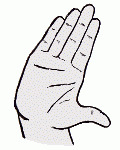
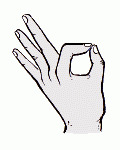
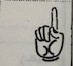
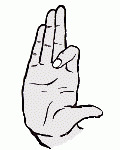
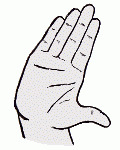
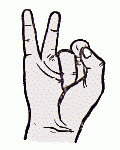
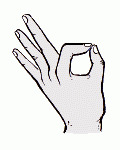
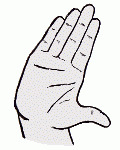
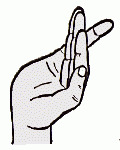
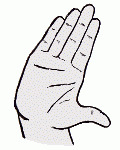
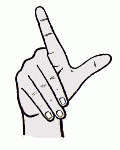
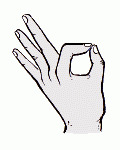
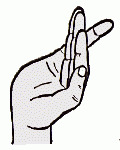
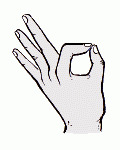
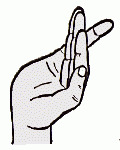
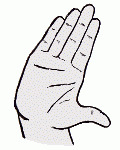
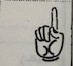
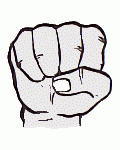
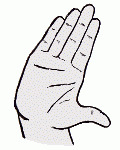
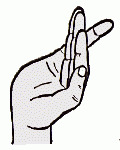
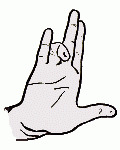
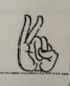
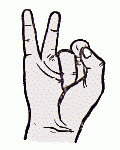
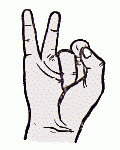
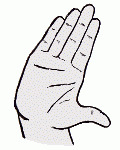
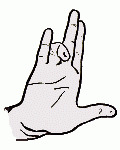
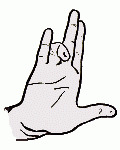
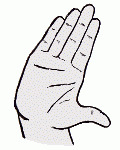
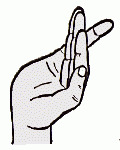
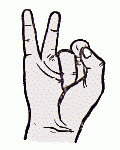
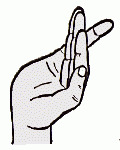
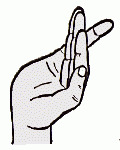
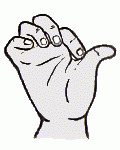
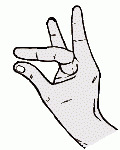
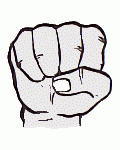
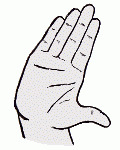
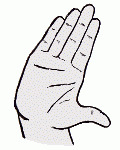
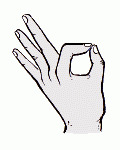
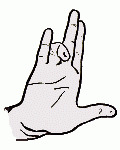
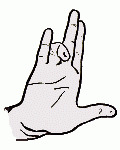

In [ ]:
def image_to_base64(path):
    with open(path, "rb") as f:
        data = f.read()
    return f'<img src="data:image/jpeg;base64,{base64.b64encode(data).decode()}" width="100">'

table_data = []
x = 0

for k, v in d0.items():
  question = k
  context = malayalam_contexts[x]
  actual_answer = malayalam_actual_answers[x]
  generated_answer = malayalam_generated_answers_roberta_large[x]
  image_htmls = []

  for j in v:
    if j not in d1:
      continue
    img_keys = d1[j] if isinstance(d1[j], list) else [d1[j]]

    for key in img_keys:
      path = d2.get(key)
      if path:
        try:
          image_htmls.append(image_to_base64(path))
        except Exception as e:
          image_htmls.append(f"(Cannnot  display the image: {e})")

  image_html = ' '.join(image_htmls)
  table_data.append([question, context, actual_answer, generated_answer, image_html])
  x += 1

df = pd.DataFrame(table_data, columns=["Question", "Context", "Actual Answer", "Generated Answer", "Images"])
df = df.reset_index(drop=True)
html_table = df.to_html(escape=False, index=False)

html_style = """
<style>
table {
  table-layout: fixed;
  width: 100%;
  max-width: 1300px;
  font-size: 14px;
}
th, td {
  word-wrap: break-word;
  text-align: center;
  vertical-align: top;
}
th:nth-child(1), td:nth-child(1) { width: 150px; }
th:nth-child(2), td:nth-child(2) { width: 150px; }
th:nth-child(3), td:nth-child(3) { width: 150px; }
th:nth-child(4), td:nth-child(4) { width: 150px; }
th:nth-child(5), td:nth-child(5) { width: 400px; }
</style>
"""

# Display styled HTML
HTML(html_style + html_table)